# Data preprocessing and model preparation

In [1]:
library(data.table) #fread
library(dplyr)
library(geosphere) # Calculate vehicle distance
library(lubridate)# Date column extraction
library(robfilter)# Smooth the data
library(ggplot2) # Plot
library(gridExtra) # Combine different plots


Attaching package: 'dplyr'


The following objects are masked from 'package:data.table':

    between, first, last


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'lubridate'


The following objects are masked from 'package:data.table':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Loading required package: robustbase

Loading required package: MASS


Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select


Loading required package: lattice


Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




In [2]:
# adjust the R limit
memory.limit(size=249200)

[1] 249200

## Input location data

In [2]:
# Read data from folder
# Suggestion: Just do one year at one time. One year's table has 94363502 rows(green)
YEARLIST = c('19')
MONTHlIST = c("04") #FOR FULL TABLE
DISTANCE_FILEPATH = "../../data/raw/vehicle-location/"

In [3]:
add_dd_mm_yy_cols = function(df) {
    df$day = day(df$trxtime)
    df$month = month(df$trxtime)
    df$year = year(df$trxtime)
    return(df)
}
get_heavy_rail_trajectories = function(year, month){
    filename = paste(DISTANCE_FILEPATH, paste(paste(c("heavyrail","trajectories",month),collapse = "-"), "-", year, ".csv",sep = ""), sep = "")
    print(filename)
    assign("df", fread(filename))
    df = add_dd_mm_yy_cols(df)
    return(df)
}

get_light_rail_trajectories = function(year, month){
    filename = paste(DISTANCE_FILEPATH, paste(paste(c("lightrail","trajectories",month),collapse = "-"), "-",  year, ".csv",sep = ""), sep = "")
    print(filename)
    assign("df", fread(filename ))
    df = add_dd_mm_yy_cols(df)
    return(df)
}

In [4]:
dlt = get_light_rail_trajectories(YEARLIST,MONTHlIST)

[1] "../../data/raw/vehicle-location/lightrail-trajectories-04-19.csv"


In [5]:
dht = get_heavy_rail_trajectories(YEARLIST,MONTHlIST)

[1] "../../data/raw/vehicle-location/heavyrail-trajectories-04-19.csv"


In [52]:
colnames(dht)

[1] "counter"           "trxtime"           "lineid"           
 [4] "trainid"           "lat"               "lon"              
 [7] "servicetypeid"     "heavyrailbranchid" "tripid"           
[10] "vehicleid"         "destination"       "rcvtime"          
[13] "inserted"          "day"               "month"            
[16] "year"

In [276]:
colnames(dlt)

[1] "counter"       "trxtime"       "lineid"        "trainid"      
 [5] "lat"           "lon"           "servicetypeid" "routeid"      
 [9] "vehicleid"     "sourceid"      "car1"          "car2"         
[13] "car3"          "speed"         "heading"       "rcvtime"      
[17] "lastavi"       "inserted"      "day"           "month"        
[21] "year"

In [190]:
# Check a few values:
print("Train ID: (head/number of unique values)")
print(head(unique(dlt$trainid)))
print(length(unique(dlt$trainid)))
print("Service Type ID: (head/number of unique values)")
print(head(unique(dlt$servicetypeid)))
print(length(unique(dlt$servicetypeid)))
print("Route ID: (head/number of unique values)")
print(head(unique(dlt$routeid)))
print(length(unique(dlt$routeid)))
print("Vehicle ID: (head/number of unique values)")
print(head(unique(dlt$vehicleid)))
print(length(unique(dlt$vehicleid)))
print("Source ID: (head/number of unique values)")
print(head(unique(dlt$sourceid)))
print(length(unique(dlt$sourceid)) )
print("Car 1: (head/number of unique values)")
print(head(unique(dlt$car1)))
print(length(unique(dlt$car1)))
print("Car 2: (head/number of unique values)")
print(head(unique(dlt$car2)))
print(length(unique(dlt$car2)))
print("Car 3: (head/number of unique values)")
print(head(unique(dlt$car3)))
print(length(unique(dlt$car3)))

[1] "Train ID: (head/number of unique values)"
[1] 10404 10358 10175 10205 10098 10025
[1] 594
[1] "Service Type ID: (head/number of unique values)"
[1]  1 NA
[1] 2
[1] "Route ID: (head/number of unique values)"
[1] 850 852 800 831 813 880
[1] 63
[1] "Vehicle ID: (head/number of unique values)"
[1] "  3628" "  3842" "  3802" "  3691" "  3829" "  3624"
[1] 233
[1] "Source ID: (head/number of unique values)"
[1]  1  2  0 NA
[1] 4
[1] "Car 1: (head/number of unique values)"
[1] 3628 3842 3802 3691 3829 3624
[1] 233
[1] "Car 2: (head/number of unique values)"
[1] 3878 3653   NA 3853 3674 3838
[1] 195
[1] "Car 3: (head/number of unique values)"
[1]   NA 3856 3820 3202 3702 3631
[1] 173


In [203]:
dlt$vehicleid = as.integer(dlt$vehicleid)

In [22]:
# check 1-1 correspondence of vehicleid/car1
# this has to be generalized for multiple trains
nrow(dlt[vehicleid!=car1 & trainid==10404 & day==2, ]) 

[1] 14

In [23]:
nrow(dlt[vehicleid!=car2 & trainid==10404 & day==2, ]) 

[1] 0

In [7]:
# small test
day_trainid_subset = dlt[day==1, .SD, keyby = .(trainid, vehicleid, routeid) ]

In [8]:
unique_train_vehicle_route_tuple = unique(day_trainid_subset[, .(trainid, vehicleid, routeid) ])

In [9]:
unique_train_vehicle_route_tuple[2]

trainid,vehicleid,routeid
<int>,<chr>,<int>
10001,3699,850


Note that in some cases (e.g. `train_vehicle_route_index = 7`, the `vehicleid` is the same as `car2`. Is this the reverse route?

In [50]:
train_vehicle_route_index = 10
trajectory = day_trainid_subset[trainid == unique_train_vehicle_route_tuple[train_vehicle_route_index,1][[1]] & 
                   vehicleid == unique_train_vehicle_route_tuple[train_vehicle_route_index,2][[1]] &
                   routeid == unique_train_vehicle_route_tuple[train_vehicle_route_index,3][[1]],][order(trxtime)]
head(trajectory[, .SD, by= .(trxtime)][,c('trxtime', 'routeid','vehicleid','car1','car2', 'car3')])
#day_trainid_subset[trainid == 10001 & vehicleid == 3699,]


trxtime,routeid,vehicleid,car1,car2,car3
<chr>,<int>,<chr>,<int>,<int>,<int>
2019-04-01 07:59:31,852,3713,3713,3876,NA
2019-04-01 07:59:37,852,3713,3713,3876,NA
2019-04-01 07:59:43,852,3713,3713,3876,NA
2019-04-01 07:59:43,852,3713,3713,3876,NA
2019-04-01 07:59:49,852,3713,3713,3876,NA
2019-04-01 07:59:55,852,3713,3713,3876,NA


In [49]:
train_vehicle_route_index = 14
trajectory = day_trainid_subset[trainid == unique_train_vehicle_route_tuple[train_vehicle_route_index,1][[1]] & 
                   vehicleid == unique_train_vehicle_route_tuple[train_vehicle_route_index,2][[1]] &
                   routeid == unique_train_vehicle_route_tuple[train_vehicle_route_index,3][[1]],][order(trxtime)]
head(trajectory[, .SD, by= .(trxtime)][,c('trxtime','routeid', 'vehicleid','car1','car2', 'car3')])
#day_trainid_subset[trainid == 10001 & vehicleid == 3699,]


trxtime,routeid,vehicleid,car1,car2,car3
<chr>,<int>,<chr>,<int>,<int>,<int>
2019-04-01 06:25:44,852,3876,3876,NA,NA
2019-04-01 06:25:50,852,3876,3876,3713,NA
2019-04-01 06:25:56,852,3876,3876,3713,NA
2019-04-01 06:25:56,852,3876,3876,3713,NA
2019-04-01 06:26:02,852,3876,3876,3713,NA
2019-04-01 06:26:02,852,3876,3876,3713,NA


This tells us we should also index by `car1` and `car2`. So here is the complete routine

In [59]:
# COMPLETE ROUTINE
day_trainid_subset = dlt[day==1, .SD, keyby = .(trainid, vehicleid, routeid) ]
unique_train_vehicle_route_car_tuple = unique(
    day_trainid_subset[, .(trainid, vehicleid, routeid, car1,car2,car3) ]
)
print(dim(unique_train_vehicle_route_car_tuple)[1])

[1] 1208


In [65]:
## This should be made into a function:
index = 1
trajectory = day_trainid_subset[
    trainid == unique_train_vehicle_route_car_tuple[index, 1][[1]] & 
    vehicleid == unique_train_vehicle_route_car_tuple[index, 2][[1]] &
    routeid == unique_train_vehicle_route_car_tuple[index, 3][[1]],][order(trxtime)]
clean_trajectory = trajectory[, .SD[1], by = trxtime] # selects the first in each time frame
#head(trajectory[, .SD, by= .(trxtime)][,c('trxtime', 'routeid','vehicleid','car1','car2', 'car3')])
#day_trainid_subset[trainid == 10001 & vehicleid == 3699,]

In [66]:
clean_trajectory

trxtime,trainid,vehicleid,routeid,counter,lineid,lat,lon,servicetypeid,sourceid,⋯,car2,car3,speed,heading,rcvtime,lastavi,inserted,day,month,year
<chr>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,⋯,<int>,<int>,<dbl>,<dbl>,<chr>,<int>,<chr>,<int>,<dbl>,<dbl>
2019-04-01 04:02:25,10001,3699,0,7237,4,42.33701,-71.25349,1,1,⋯,NA,NA,0.00,24.19,2019-04-01 04:02:26,0,2019-04-19 15:20:20,1,4,2019
2019-04-01 04:02:37,10001,3699,0,7240,4,42.33710,-71.25371,1,1,⋯,NA,NA,0.00,24.19,2019-04-01 04:02:37,0,2019-04-19 15:20:20,1,4,2019
2019-04-01 04:11:44,10001,3699,0,7241,4,42.33701,-71.25349,1,1,⋯,NA,NA,0.00,24.19,2019-04-01 04:11:44,0,2019-04-19 15:20:20,1,4,2019
2019-04-01 04:27:21,10001,3699,0,7244,4,42.33710,-71.25371,1,1,⋯,NA,NA,0.00,24.19,2019-04-01 04:27:21,0,2019-04-19 15:20:20,1,4,2019
2019-04-01 04:28:46,10001,3699,0,7246,4,42.33701,-71.25349,1,1,⋯,NA,NA,0.00,24.19,2019-04-01 04:28:47,0,2019-04-19 15:20:20,1,4,2019
2019-04-01 04:44:12,10001,3699,0,7258,4,42.33710,-71.25371,1,1,⋯,NA,NA,0.00,24.19,2019-04-01 04:44:12,0,2019-04-19 15:20:20,1,4,2019
2019-04-01 06:09:50,10001,3699,0,13277,4,42.33701,-71.25349,1,1,⋯,NA,NA,0.00,24.19,2019-04-01 06:09:51,0,2019-04-19 15:20:20,1,4,2019
2019-04-01 06:17:16,10001,3699,0,14323,4,42.33710,-71.25371,1,1,⋯,NA,NA,0.00,24.19,2019-04-01 06:17:16,0,2019-04-19 15:20:20,1,4,2019
2019-04-01 06:18:04,10001,3699,0,14431,4,42.33701,-71.25349,1,1,⋯,NA,NA,0.00,24.19,2019-04-01 06:18:05,0,2019-04-19 15:20:20,1,4,2019


Extras (still to be polished)

In [171]:
# count unique trainid each month
for (line in unique(dlt$lineid)) {
    for (train in unique(dlt$trainid)) 
}
dlt[day==1, print(.SD), by=.(lineid, trainid, servicetypeid, routeid, vehicleid, sourceid, car1, car2, car3)]#[order(trainid, trxtime)]

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



lineid,trainid,servicetypeid,routeid,vehicleid,sourceid,car1,car2,car3
<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>


In [123]:
#setkey(dht, tripid)

In [115]:
#count unique train id by line
print(dim(unique(dht[lineid==1][,c('tripid')])))
print(dim(unique(dht[lineid==2][,c('tripid')])))
print(dim(unique(dht[lineid==3][,c('tripid')])))
#dht[, .N,  by=.(lineid)]#[order(lineid)]

[1] 13850     1
[1] 10957     1
[1] 9163    1


In [166]:
dht[, .(.N), by = .(lineid)]

lineid,N
<int>,<int>
1,882756
2,496444
3,641897


In [46]:
dlt[trainid==10404]

counter,trxtime,lineid,trainid,lat,lon,servicetypeid,routeid,vehicleid,sourceid,⋯,car2,car3,speed,heading,rcvtime,lastavi,inserted,day,month,year
<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<chr>,<int>,⋯,<int>,<int>,<dbl>,<dbl>,<chr>,<int>,<chr>,<int>,<dbl>,<dbl>
16244,2019-04-18 02:00:03,4,10404,42.33680,-71.25352,1,850,3628,1,⋯,3878,NA,0,26.84,2019-04-18 02:00:03,35,2019-04-19 11:42:03,18,4,2019
16245,2019-04-18 02:00:03,4,10404,42.33668,-71.25398,1,850,3628,1,⋯,3878,NA,0,27.80,2019-04-18 02:00:04,35,2019-04-19 11:42:03,18,4,2019
16246,2019-04-18 02:00:03,4,10404,42.33658,-71.25367,1,850,3628,1,⋯,3878,NA,0,27.80,2019-04-18 02:00:04,35,2019-04-19 11:42:03,18,4,2019
16250,2019-04-18 02:00:09,4,10404,42.33680,-71.25352,1,850,3628,1,⋯,3878,NA,0,26.84,2019-04-18 02:00:09,35,2019-04-19 11:42:03,18,4,2019
16251,2019-04-18 02:00:09,4,10404,42.33668,-71.25398,1,850,3628,1,⋯,3878,NA,0,27.80,2019-04-18 02:00:10,35,2019-04-19 11:42:03,18,4,2019
16252,2019-04-18 02:00:09,4,10404,42.33658,-71.25367,1,850,3628,1,⋯,3878,NA,0,27.80,2019-04-18 02:00:10,35,2019-04-19 11:42:03,18,4,2019
16256,2019-04-18 02:00:15,4,10404,42.33680,-71.25352,1,850,3628,1,⋯,3878,NA,0,26.84,2019-04-18 02:00:15,35,2019-04-19 11:42:03,18,4,2019
16257,2019-04-18 02:00:15,4,10404,42.33668,-71.25398,1,850,3628,1,⋯,3878,NA,0,27.80,2019-04-18 02:00:16,35,2019-04-19 11:42:03,18,4,2019
16258,2019-04-18 02:00:15,4,10404,42.33658,-71.25367,1,850,3628,1,⋯,3878,NA,0,27.80,2019-04-18 02:00:16,35,2019-04-19 11:42:03,18,4,2019


In [49]:
#length(unique(dlt$trainid))
dlt[trainid==10404 , .N, by=.(trainid, car1, car2, car3)][order(trainid)]

trainid,car1,car2,car3,N
<int>,<int>,<int>,<int>,<int>
10404,3628,3878,NA,10315
10404,3691,NA,NA,38
10404,3691,3833,NA,169
10404,NA,NA,NA,6
10404,3643,NA,NA,14
10404,3809,NA,NA,36
10404,3861,NA,NA,2
10404,3000,NA,NA,6
10404,3813,NA,NA,48


In [22]:
dht1 = dht[dht$lineid==1]
length(unique(dht1$trainid))
head(dht1)

[1] 760

counter,trxtime,lineid,trainid,lat,lon,servicetypeid,heavyrailbranchid,tripid,vehicleid,destination,rcvtime,inserted,day,month,year
<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int64>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>
4710,2019-04-18 02:02:11,1,1415357484,42.39626,-71.13846,0,0,2550365243,L1849,NA,2019-04-18 02:02:12,2019-04-19 11:41:59,18,4,2019
4711,2019-04-18 02:02:35,1,1415357484,42.39601,-71.14006,0,0,2550365243,L1849,NA,2019-04-18 02:02:35,2019-04-19 11:41:59,18,4,2019
4712,2019-04-18 02:02:35,1,1415357484,42.39618,-71.14054,0,0,2550365243,L1849,NA,2019-04-18 02:02:35,2019-04-19 11:41:59,18,4,2019
4714,2019-04-18 02:18:20,1,1415355858,42.28125,-71.06165,0,1,2550365168,L1618,NA,2019-04-18 02:18:20,2019-04-19 11:41:59,18,4,2019
4715,2019-04-18 02:18:59,1,1415355858,0.00000,0.00000,0,0,0,L1618,NA,2019-04-18 02:18:59,2019-04-19 11:41:59,18,4,2019
4716,2019-04-18 02:18:59,1,1415355858,0.00000,0.00000,NA,NA,NA,NA,NA,2019-04-18 02:18:59,2019-04-19 11:41:59,18,4,2019


In [24]:
dht1$time = as.POSIXct(dht1$trxtime,"%Y:%M:%D:%H:%M:%S")

In [34]:
head(dht1)

counter,trxtime,lineid,trainid,lat,lon,servicetypeid,heavyrailbranchid,tripid,vehicleid,destination,rcvtime,inserted,day,month,year,time
<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int64>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dttm>
4710,2019-04-18 02:02:11,1,1415357484,42.39626,-71.13846,0,0,2550365243,L1849,NA,2019-04-18 02:02:12,2019-04-19 11:41:59,18,4,2019,2019-04-18 02:02:11
4711,2019-04-18 02:02:35,1,1415357484,42.39601,-71.14006,0,0,2550365243,L1849,NA,2019-04-18 02:02:35,2019-04-19 11:41:59,18,4,2019,2019-04-18 02:02:35
4712,2019-04-18 02:02:35,1,1415357484,42.39618,-71.14054,0,0,2550365243,L1849,NA,2019-04-18 02:02:35,2019-04-19 11:41:59,18,4,2019,2019-04-18 02:02:35
4714,2019-04-18 02:18:20,1,1415355858,42.28125,-71.06165,0,1,2550365168,L1618,NA,2019-04-18 02:18:20,2019-04-19 11:41:59,18,4,2019,2019-04-18 02:18:20
4715,2019-04-18 02:18:59,1,1415355858,0.00000,0.00000,0,0,0,L1618,NA,2019-04-18 02:18:59,2019-04-19 11:41:59,18,4,2019,2019-04-18 02:18:59
4716,2019-04-18 02:18:59,1,1415355858,0.00000,0.00000,NA,NA,NA,NA,NA,2019-04-18 02:18:59,2019-04-19 11:41:59,18,4,2019,2019-04-18 02:18:59


In [33]:
dht1[day==18, .N, by = .(trainid, vehicleid)][order(trainid,vehicleid)]

trainid,vehicleid,N
<int>,<chr>,<int>
1415341881,1801,17
1415341881,1873,61
1415341881,L1801,10
1415341881,NA,1
1415352109,1504,572
1415352109,1732,583
1415352109,L1732,2
1415352530,1843,60
1415352530,1864,26


In [ ]:
#options(repr.plot.width = 8, repr.plot.height = 8)
ggplot(dht1) + 
    geom_point(aes(x = lon, y = lat, color = factor(hour)),size = 1,alpha = 0.4) +
    theme(axis.text=element_text(size = 12),axis.title.x = element_text(size = 20),axis.title.y = element_text(size = 20),title= element_text(size = 20)) +
    labs(title =" lon vs lat ", y = "Latitude", x = "Longitude")

In [7]:
# aggregrate_trajectory_table
aggregate_line_trajectories = function(year, month){
    assign("dg", fread(paste(DISTANCE_FILEPATH, paste(paste(c("lightrail","trajectories",month, year),collapse = "-"),".csv",sep = ""), sep = "")))
    assign("dh", fread(paste(DISTANCE_FILEPATH, paste(paste(c("heavyrail","trajectories",month, year),collapse = "-"),".csv",sep = ""), sep = "")))
    # Combine the original tables to a single one for analysis
    print(colnames(dg))
    print(colnames(dh))
    dg = subset(dg, select = c(trxtime, trainid, lineid, lat, lon))
    dh = subset(dh, select = c(trxtime, trainid, lineid, lat, lon))
    df = rbind(dg, dh)
    return(df)
}

In [8]:
df = aggregate_line_trajectories(YEARLIST,MONTHlIST)

 [1] "counter"       "trxtime"       "lineid"        "trainid"      
 [5] "lat"           "lon"           "servicetypeid" "routeid"      
 [9] "vehicleid"     "sourceid"      "car1"          "car2"         
[13] "car3"          "speed"         "heading"       "rcvtime"      
[17] "lastavi"       "inserted"     
 [1] "counter"           "trxtime"           "lineid"           
 [4] "trainid"           "lat"               "lon"              
 [7] "servicetypeid"     "heavyrailbranchid" "tripid"           
[10] "vehicleid"         "destination"       "rcvtime"          
[13] "inserted"         


In [6]:
df

trxtime,trainid,lineid,lat,lon
<chr>,<int>,<int>,<dbl>,<dbl>
2019-04-18 02:00:03,10404,4,42.33680,-71.25352
2019-04-18 02:00:03,10404,4,42.33668,-71.25398
2019-04-18 02:00:03,10404,4,42.33658,-71.25367
2019-04-18 02:00:04,10358,4,42.33658,-71.25367
2019-04-18 02:00:04,10358,4,42.33645,-71.25413
2019-04-18 02:00:04,10358,4,42.33635,-71.25379
2019-04-18 02:00:09,10404,4,42.33680,-71.25352
2019-04-18 02:00:09,10404,4,42.33668,-71.25398
2019-04-18 02:00:09,10404,4,42.33658,-71.25367


## Data preprocessing

In [6]:
# Data preprocessing
preprocess_data = function(df){
    # Add time column to do analysis by random time scale
    df$day = day(df$trxtime)
    df$month = month(df$trxtime)
    df$year = year(df$trxtime)
    # check the na values ratio
    df_zero = df[df$lon == 0 | df$lat == 0,]
    df_zero_rate = nrow(df_zero)/nrow(df)
    print(df_zero_rate)
    # remove the rows with values of lat and lon are 0/NA
    df = df[!(is.na(df$lon)) | !(is.na(df$lat)),]
    df = df[df$lon != 0 | df$lat != 0,]
    df = df[order(df$trainid, df$trxtime),]
    df = distinct(df, trxtime, trainid, .keep_all = TRUE) # Remove the duplicated time record
    return(df)
}

In [7]:
df = preprocess_data(df)

[1] 0.0008356593


In [10]:
df_test_1415375776 = subset(df,trainid == 1415375776)

### Smoothing methods

In [ ]:
#df_test$dist_meters
filter = robreg.filter(df_test_computed$dist_meters, width=10,online=TRUE,method= "MED")

In [63]:
width = 10
right.width = 10

In [51]:
filter_wrm = wrm.filter(df_test_computed$dist_meters, width,weight.type = 1, del = floor(width/2), extrapolate = TRUE)

In [64]:
filter_scarm = scarm.filter(df_test_computed$dist_meters,right.width, min.left.width=right.width,
min.width=floor(right.width/3), max.width=200,sign.level=0.001, bound.noise.sd=0.01, rtr=TRUE,autocorrelations="automatic")

Warning message in scarm.filter(df_test_computed$dist_meters, right.width, min.left.width = right.width, :
"'min.width' must be an integer >=5; 'min.width' is set to 5.
"


In [70]:
filter_rmfilter = rm.filter(df_test_computed$dist_meters, width, minNonNAs = 5, online = FALSE, extrapolate = TRUE)

1 out of 255 time series values in y are missing. 


In [11]:
head(df_test_1415375776)

trxtime,trainid,lineid,lat,lon,day,month,year
<chr>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
2019-04-30 20:23:51,1415375776,3,42.40392,-71.07747,30,4,2019
2019-04-30 20:43:41,1415375776,3,42.40669,-71.07697,30,4,2019
2019-04-30 20:45:26,1415375776,3,42.41500,-71.07683,30,4,2019
2019-04-30 20:46:00,1415375776,3,42.42273,-71.07593,30,4,2019
2019-04-30 20:46:37,1415375776,3,42.42668,-71.07428,30,4,2019
2019-04-30 20:47:04,1415375776,3,42.42861,-71.07350,30,4,2019


### test result

In [72]:
d1 = df_test_computed
d1$dist_meters = filter_rmfilter$level$RM
d1_speed_accel = compute_speed_acceleration(d1)

Warning message in as.POSIXlt.POSIXct(x):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'

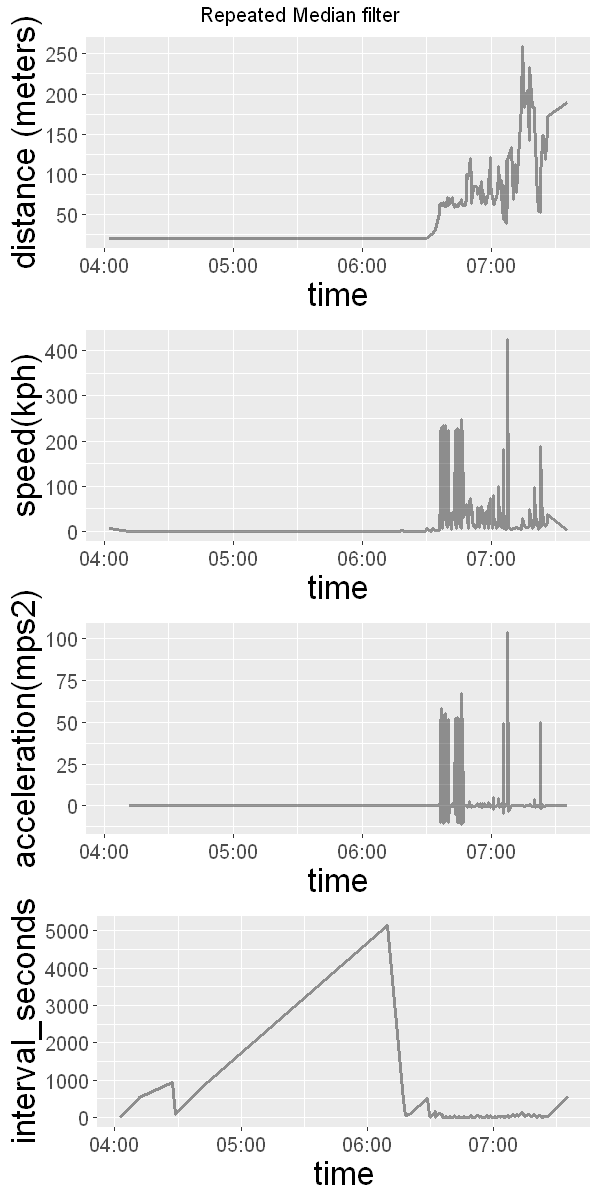

In [75]:
p6 = ggplot(d1_speed_accel) + 
 geom_line(aes(x = time, y=dist_meters),size = 1,alpha = 0.4) +
theme(axis.text=element_text(size = 12),axis.title.x = element_text(size = 20),axis.title.y = element_text(size = 20),title= element_text(size = 20))+
 labs(y = "distance (meters)", x = "time")
p7 =  ggplot(d1_speed_accel) + 
 geom_line(aes(x = time, y=speed_kph),size = 1,alpha = 0.4) +
theme(axis.text=element_text(size = 12),axis.title.x = element_text(size = 20),axis.title.y = element_text(size = 20),title= element_text(size = 20))+
 labs( y = "speed(kph)", x = "time")
p8 = ggplot(d1_speed_accel) + 
 geom_line(aes(x = time, y=accel_mps2),size = 1,alpha = 0.4) +
theme(axis.text=element_text(size = 12),axis.title.x = element_text(size = 20),axis.title.y = element_text(size = 20),title= element_text(size = 20))+
 labs(y = "acceleration(mps2)", x = "time")
p9 = ggplot(d1_speed_accel) + 
 geom_line(aes(x = time, y=interval_seconds),size = 1,alpha = 0.4) +
theme(axis.text=element_text(size = 12),axis.title.x = element_text(size = 20),axis.title.y = element_text(size = 20),title= element_text(size = 20))+
 labs(y = "interval_seconds", x = "time")
options(repr.plot.width = 5, repr.plot.height = 10)
grid.arrange(p6, p7, p8, p9, ncol=1, nrow=4,top ="Result before filter")

In [10]:
train_test = function(trainid){
    df_test = subset(df,day == 30 & trainid == trainid)
    df_test_computed  = compute_distance(df_test)
    df_test_computed = compute_speed_acceleration(df_test_computed)
    df_test_computed$time = as.POSIXct(df_test_computed$trxtime,"%Y:%M:%D:%H:%M:%S")
    p1 = ggplot(df_test_computed) + 
    geom_line(aes(x = time, y=dist_meters),size = 1,alpha = 0.4) +
    theme(axis.text=element_text(size = 12),axis.title.x = element_text(size = 20),axis.title.y = element_text(size = 20),title= element_text(size = 20))+
    labs(y = "distance (meters)", x = "hour")
    p2 =  ggplot(df_test_computed) + 
    geom_line(aes(x = time, y=speed_kph),size = 1,alpha = 0.4) +
    theme(axis.text=element_text(size = 12),axis.title.x = element_text(size = 20),axis.title.y = element_text(size = 20),title= element_text(size = 20))+
    labs( y = "speed(kph)", x = "hour")
    p3 = ggplot(df_test_computed) + 
    geom_line(aes(x = time, y=accel_mps2),size = 1,alpha = 0.4) +
    theme(axis.text=element_text(size = 12),axis.title.x = element_text(size = 20),axis.title.y = element_text(size = 20),title= element_text(size = 20))+
    labs(y = "acceleration(mps2)", x = "hour")
    p4 = ggplot(df_test_computed) + 
    geom_line(aes(x = time, y=interval_seconds),size = 1,alpha = 0.4) +
    theme(axis.text=element_text(size = 12),axis.title.x = element_text(size = 20),axis.title.y = element_text(size = 20),title= element_text(size = 20))+
    labs(y = "interval_seconds", x = "hour")
    options(repr.plot.width = 5, repr.plot.height = 10)
    grid.arrange(p1, p2, p3, p4, ncol = 1, nrow = 4,top ="Result before filter")
    return(df_test_computed)
}

Warning message in strptime(xx, f, tz = tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(x):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in strptime(x, f, tz = tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(as.POSIXlt(x, tz, ...), tz, ...):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x):
"unknown timezon

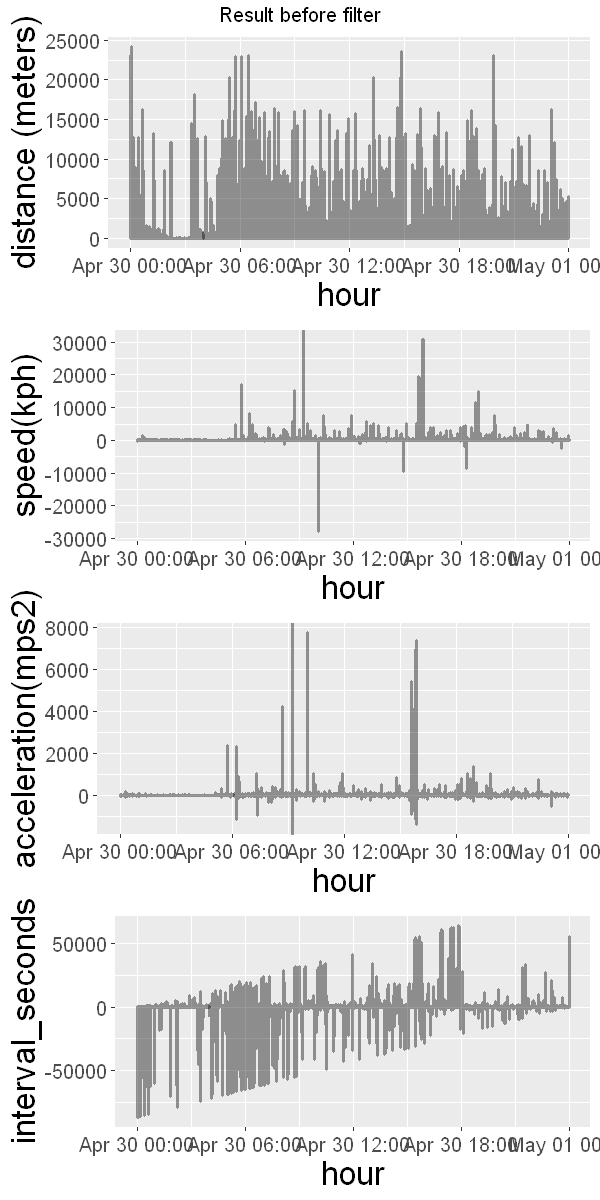

In [11]:
d_test = train_test(1415375776)

In [12]:
head(d_test)

Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"


,trxtime,trainid,lineid,lat,lon,day,month,year,dist_meters,interval_seconds,speed_mps,speed_kph,accel_mps2,time
,<chr>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>
1,2019-04-30 04:00:01,10001,4,42.33623,-71.25426,30,4,2019,NA,NA,NA,NA,NA,2019-04-30 04:00:01
2,2019-04-30 06:06:13,10001,4,42.33635,-71.25379,30,4,2019,40.27217,7572,0.005318564,0.01914683,NA,2019-04-30 06:06:13
3,2019-04-30 06:06:20,10001,4,42.33658,-71.25367,30,4,2019,28.08000,7,4.011428592,14.44114293,0.57230143,2019-04-30 06:06:20
4,2019-04-30 06:06:26,10001,4,42.33680,-71.25352,30,4,2019,26.95307,6,4.492178876,16.17184395,0.08012505,2019-04-30 06:06:26
5,2019-04-30 06:09:15,10001,4,42.33696,-71.25329,30,4,2019,26.68781,169,0.157916058,0.56849781,-0.02564653,2019-04-30 06:09:15
6,2019-04-30 06:10:15,10001,4,42.33689,-71.25384,30,4,2019,46.45064,60,0.774177308,2.78703831,0.01027102,2019-04-30 06:10:15


In [14]:
min(d_test$interval_seconds,na.rm =NA)

[1] -86388

In [17]:
d_test[d_test$interval_seconds == -86388 & d_test$trainid == 1415375776,]

Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"


trxtime,trainid,lineid,lat,lon,day,month,year,dist_meters,interval_seconds,speed_mps,speed_kph,accel_mps2,time
<chr>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>


In [12]:
d_test$hour = hour(d_test$trxtime)

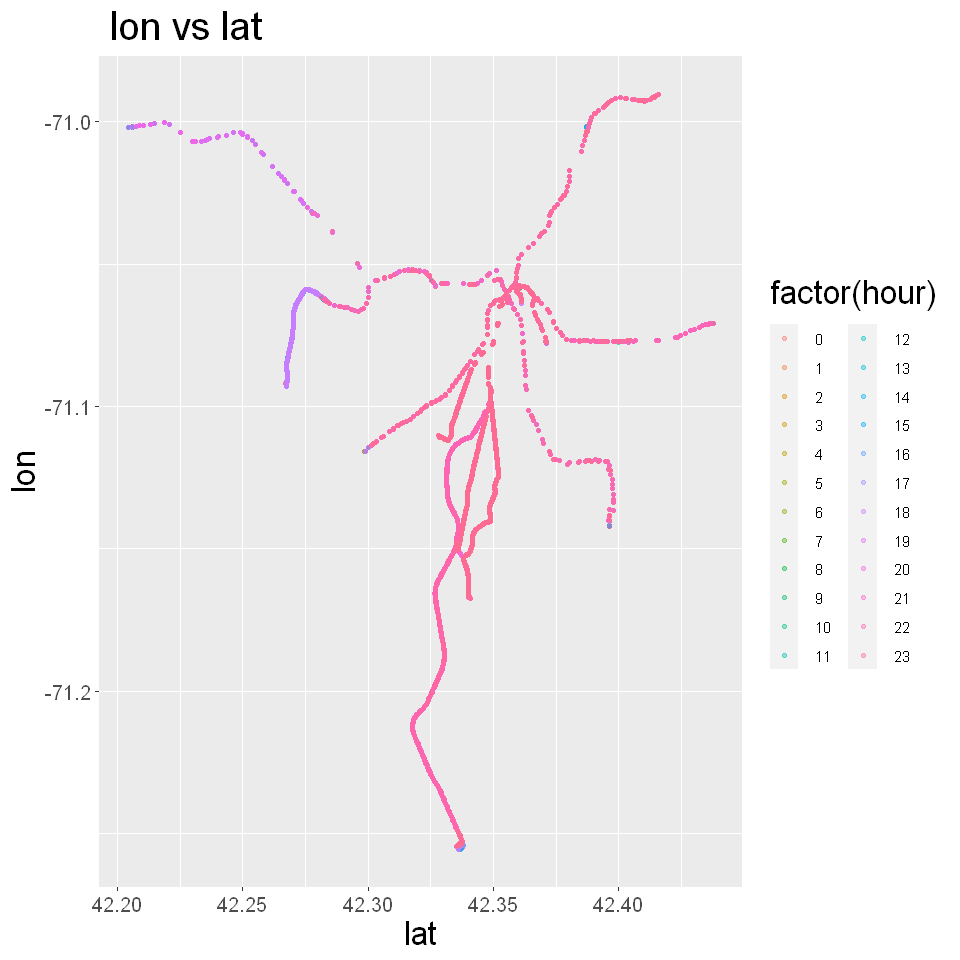

In [17]:
options(repr.plot.width = 8, repr.plot.height = 8)
ggplot(d_test) + 
    geom_point(aes(x = lat, y = lon,color = factor(hour)),size = 1,alpha = 0.4) +
    theme(axis.text=element_text(size = 12),axis.title.x = element_text(size = 20),axis.title.y = element_text(size = 20),title= element_text(size = 20)) +
    labs(title =" lon vs lat ", y = "lon", x = "lat")

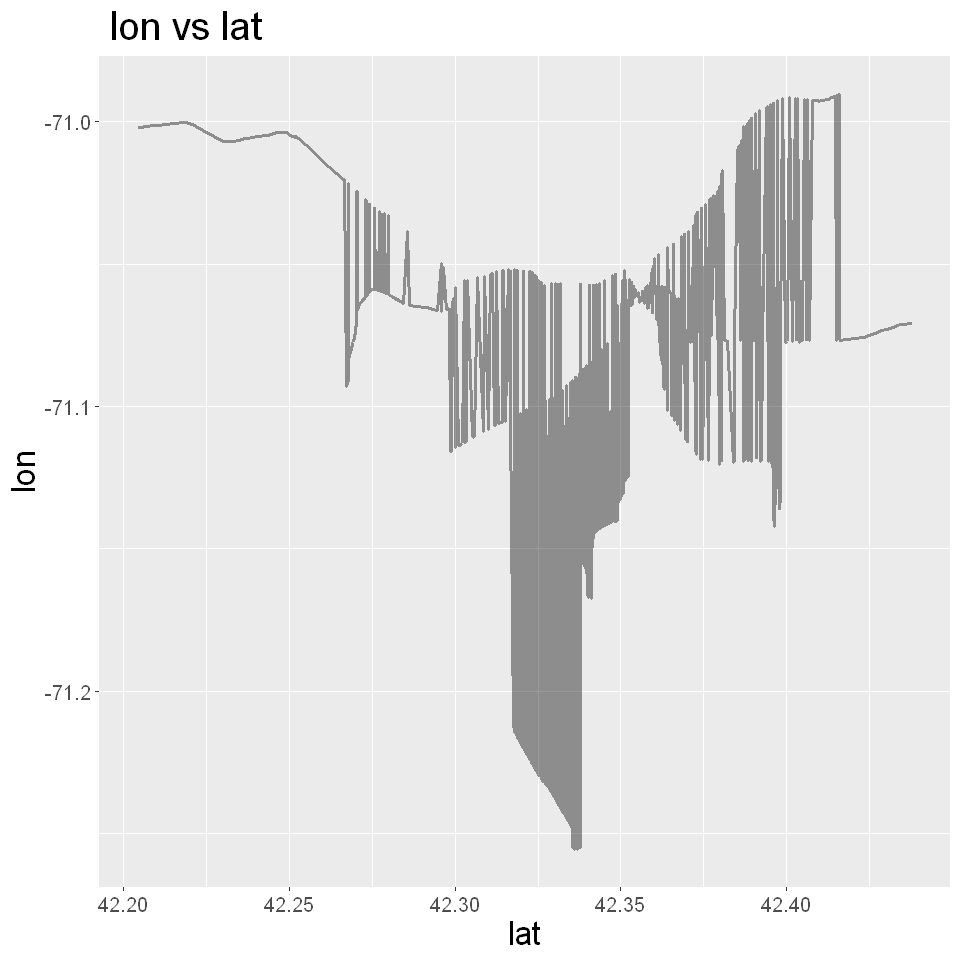

In [16]:
options(repr.plot.width = 8, repr.plot.height = 8)
ggplot(d_test) + 
    geom_line(aes(x = lat, y = lon),size = 1,alpha = 0.4) +
    theme(axis.text=element_text(size = 12),axis.title.x = element_text(size = 20),axis.title.y = element_text(size = 20),title= element_text(size = 20)) +
    labs(title =" lon vs lat ", y = "lon", x = "lat")

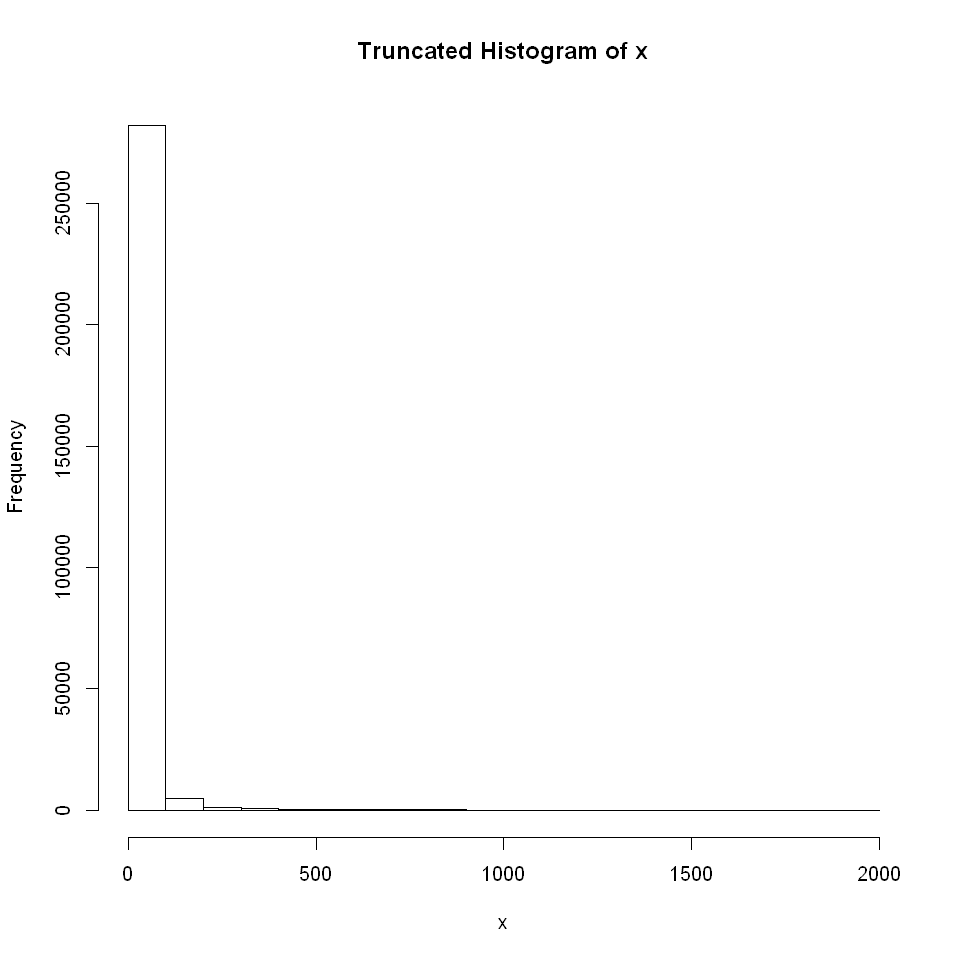

In [32]:
truncHist(d_test$interval_seconds,xmin = 0,xmax = 2000)

In [35]:
min(d_test$interval_seconds,na.rm = TRUE)

[1] -86388

Warning message in as.POSIXlt.POSIXct(x):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
War

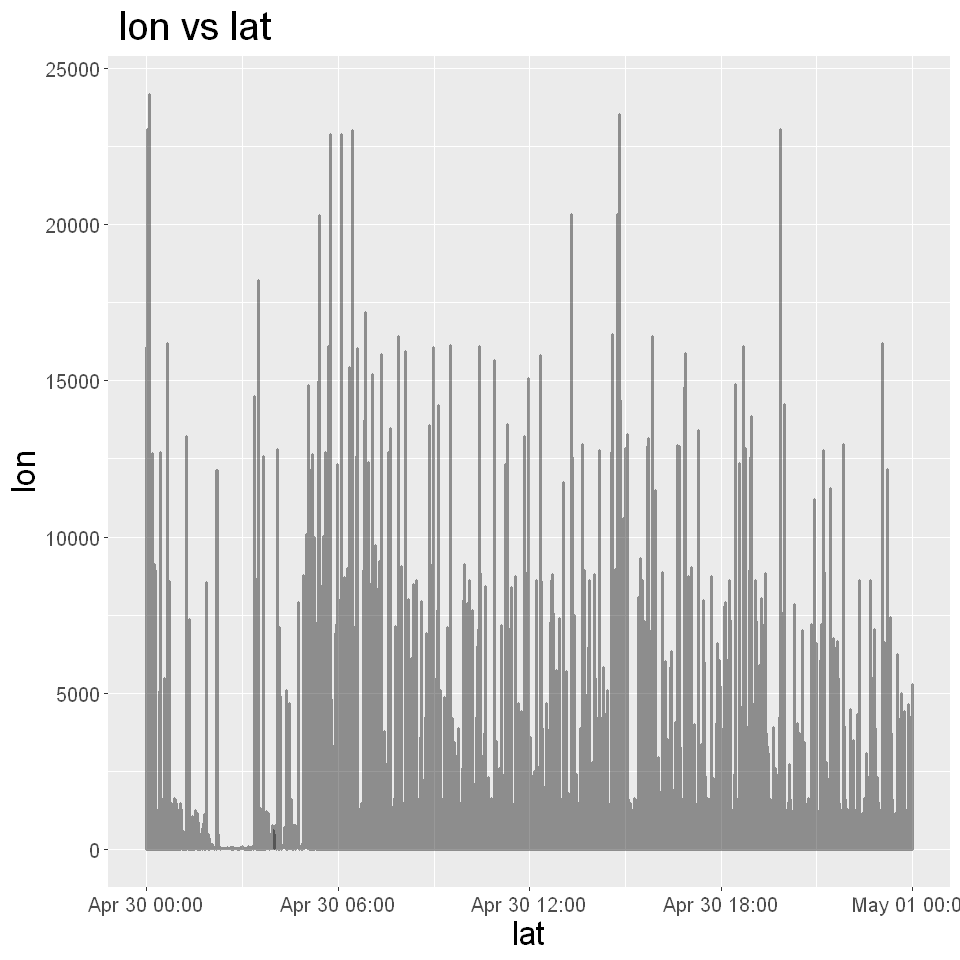

In [37]:
ggplot(d_test) + 
    geom_line(aes(x = time, y = dist_meters),size = 1,alpha = 0.4) +
    theme(axis.text=element_text(size = 12),axis.title.x = element_text(size = 20),axis.title.y = element_text(size = 20),title= element_text(size = 20)) +
    labs(title =" lon vs lat ", y = "lon", x = "lat")

In [36]:
head(d_test)

Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"


,trxtime,trainid,lineid,lat,lon,day,month,year,dist_meters,interval_seconds,speed_mps,speed_kph,accel_mps2,time,hour
,<chr>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<int>
1,2019-04-30 04:00:01,10001,4,42.33623,-71.25426,30,4,2019,NA,NA,NA,NA,NA,2019-04-30 04:00:01,4
2,2019-04-30 06:06:13,10001,4,42.33635,-71.25379,30,4,2019,40.27217,7572,0.005318564,0.01914683,NA,2019-04-30 06:06:13,6
3,2019-04-30 06:06:20,10001,4,42.33658,-71.25367,30,4,2019,28.08000,7,4.011428592,14.44114293,0.57230143,2019-04-30 06:06:20,6
4,2019-04-30 06:06:26,10001,4,42.33680,-71.25352,30,4,2019,26.95307,6,4.492178876,16.17184395,0.08012505,2019-04-30 06:06:26,6
5,2019-04-30 06:09:15,10001,4,42.33696,-71.25329,30,4,2019,26.68781,169,0.157916058,0.56849781,-0.02564653,2019-04-30 06:09:15,6
6,2019-04-30 06:10:15,10001,4,42.33689,-71.25384,30,4,2019,46.45064,60,0.774177308,2.78703831,0.01027102,2019-04-30 06:10:15,6


In [43]:
d_test[d_test$interval_seconds < 0,c("interval_seconds")]

[1]     NA  -7932 -22448  -4215   -400  -6391 -11169 -78130  -8010  -1192
 [11] -66387  -9272 -83991  -6009 -58023 -68116 -67975   -257 -53762 -33447
 [21] -62078  -3147  -2104 -10452   -572  -5983  -1081 -41154 -66532  -4733
 [31] -59229 -56292   -526   -542 -47448 -19744  -2325 -86352 -49388 -39323
 [41]   -719 -73959 -28803   -780  -1827 -65616  -2350 -65451   -521 -62071
 [51] -77722 -35200 -64404 -85716  -1195   -465   -960 -45983 -11140 -21973
 [61] -60943 -64699 -46452 -21767   -669 -55474   -578 -86349 -17318 -63965
 [71] -64009    -82   -727   -397 -41830   -144 -61878 -18260 -18182 -12864
 [81]   -850   -923 -28392  -1026 -53134 -12889 -63272 -63172   -882 -63129
 [91] -10338 -59562  -1913   -401 -34070 -23777  -3137 -32565 -28166 -21319
[101] -61463 -61040 -53068 -32472 -61470   -442 -22130 -26296  -1535 -52780
[111]  -2951 -86178 -61001   -171 -42877  -4929 -60454 -13148 -59623 -59817
[121]   -910 -60030 -26439   -635 -28644  -8392  -4322 -45365 -43481  -1564
[131]  -1514   -358 -58499 -22075 -41384 -21552  -5689  -8911   -496  -1989
[141] -17834 -29394 -55079   -901    -18 -29611  -2994     -3 -56310 -26153
[151] -52439  -1076  -3433   -281 -31515 -54860 -31539    -41   -842  -2903
[161] -32878  -4024 -32290 -19682 -41027   -378 -83152 -86388  -1663  -2172
[171] -41187  -2000   -468   -698 -19574 -38083  -6893     -1 -38141  -2483
[181] -36736 -36680  -2908   -723 -13573 -37558 -42178 -48626  -4066   -870
[191] -34640 -32306  -2152  -2331 -22929  -5100 -42622 -31386  -1462  -2074
[201]   -320 -49609 -22062   -423 -34042 -30424  -1767  -1773   -185    -55
[211] -41157     -4  -1195  -1871  -1785    -86   -108 -28384 -85798  -8513
[221]  -1540  -2882  -1829  -1386   -574   -240 -36493  -5854    -37   -310
[231]    -64  -2426   -137  -5385  -1891  -8713   -534     -3  -4627 -18353
[241] -86303 -61402 -30713 -56702 -58251 -44680 -55584 -11454 -21686 -25522
[251] -56862   -481   -978  -3159  -1409  -2154 -22211   -144  -5623   -103
[261]  -1222  -7814 -81634  -2267 -60876    -98    -87 -60685  -1669  -1423
[271]  -5859  -3050   -321 -62384 -63140  -2807 -62950 -59688 -67196 -84916
[281] -61796  -1945 -63802 -62939 -70274 -17539    -48  -8156  -1922  -1990
[291]   -303 -21104    -11     -3  -1865  -2710   -516  -1758  -1588  -2053
[301]  -5563   -700  -1142  -9244  -1877  -3457     -8 -16721   -369   -264
[311]  -1594  -1612 -16235   -269   -205  -1577  -2460  -1104 -10854  -3875
[321]   -689 -12753   -955  -1844  -7750  -9555   -916  -1762  -1039  -1292
[331]   -255  -6150  -9984 -10096  -6824  -9341  -3650   -659  -1172  -1084
[341]  -4698  -1601   -286  -1797    -23  -1962  -3498  -5404  -3224  -1608
[351]  -3805  -3221   -107   -261  -2838   -902     -6   -591   -838   -414
[361] -61610 -41755  -3598 -78401 -69134 -27579 -70457    -33  -3017 -85858
[371]   -581 -80383  -4079  -2027   -960 -47904 -73797 -86376 -27008 -66703
[381] -76165  -3650  -2848 -27728 -61666 -72632 -69140  -6548 -11106 -86332
[391]  -4919  -4052 -55137 -75160  -2914  -2723 -86332 -86368  -1249 -71603
[401] -23011 -22480 -68531 -53773 -67485 -58284 -68204 -67670 -52998 -68885
[411] -19114 -12401 -21572 -17108 -52589 -50457 -11555 -67522 -13507 -57223
[421] -66432 -46568 -16413 -64629 -19475 -46849 -13758 -48976 -63731 -41790
[431] -12311 -14817 -54197  -3315 -24361 -28306 -38218 -36854 -32191 -18317
[441] -34356 -15408 -13799 -18648 -31499 -32609 -18309 -32961 -33006 -32172
[451]   -259 -28798 -15383   -990 -12920  -9943

In [28]:
library(jmuOutlier)

Warning message:
"package 'jmuOutlier' was built under R version 3.6.3"


### Day 1 10001 test

In [8]:
compute_distance <- function(d) {
    d = data.frame(d)
    d$dist_meters = NA
    d$dist_meters = as.numeric(d$dist_meters)
    d$interval_seconds = NA
    d$interval_seconds = as.numeric(d$interval_seconds)
    n <- nrow(d)
    if (n >= 2) {
        # Compute interval distance using Haversine function
        d$dist_meters[2:n] = distHaversine(cbind(d$lon[1:n-1],d$lat[1:n-1]),cbind(d$lon[2:n],d$lat[2:n]))
        # Compute time interval
        d$interval_seconds[2:n] = as.numeric(difftime(d$trxtime[2:n], d$trxtime[1:n-1], units = "secs"))
        }
    return(d)
}

In [9]:
compute_speed_acceleration <- function(d) {
    d = data.frame(d)
    d$speed_mps = NA
    d$speed_mps = as.numeric(d$speed_mps)
    d$speed_kph = NA
    d$speed_kph = as.numeric(d$speed_kph)
    d$accel_mps2 = NA
    d$accel_mps2 = as.numeric(d$accel_mps2)
    n <- nrow(d)
    if (n >= 2) {
        d$speed_mps[2:n] = d$dist_meters[2:n] / d$interval_seconds[2:n]
        # Convert speed to kph
        d$speed_kph[2:n] = d$speed_mps[2:n] * 3.6
        d$accel_mps2[2:n] = (d$speed_mps[2:n] - d$speed_mps[1:n-1])/d$interval_seconds[2:n]
        }
    return(d)
}       

In [42]:
d1_speed_accel = compute_speed_acceleration(d1)

In [14]:
#df_test$dist_meters
filter = robreg.filter(df_test_computed$dist_meters, width=10,online=TRUE,method= "MED")

1 out of 255 time series values in df_test_computed$dist_meters are missing. 


In [23]:
d1 = df_test_computed

In [28]:
head(d1_speed_accel)

Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"


,trxtime,trainid,lineid,lat,lon,day,month,year,dist_meters,interval_seconds,speed_mps,speed_kph,accel_mps2,time
,<chr>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>
1,2019-04-01 04:02:25,10001,4,42.33701,-71.25349,1,4,2019,20.55303,NA,NA,NA,NA,2019-04-01 04:02:25
2,2019-04-01 04:02:37,10001,4,42.33710,-71.25371,1,4,2019,20.55303,12,1.71275229,6.16590825,NA,2019-04-01 04:02:37
3,2019-04-01 04:11:44,10001,4,42.33701,-71.25349,1,4,2019,20.55303,547,0.03757409,0.13526673,-3.062483e-03,2019-04-01 04:11:44
4,2019-04-01 04:27:21,10001,4,42.33710,-71.25371,1,4,2019,20.55303,937,0.02193493,0.07896574,-1.669068e-05,2019-04-01 04:27:21
5,2019-04-01 04:28:46,10001,4,42.33701,-71.25349,1,4,2019,20.55303,85,0.24180032,0.87048117,2.586652e-03,2019-04-01 04:28:46
6,2019-04-01 04:44:12,10001,4,42.33710,-71.25371,1,4,2019,20.55303,926,0.02219549,0.07990378,-2.371542e-04,2019-04-01 04:44:12


Warning message in as.POSIXlt.POSIXct(x):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'

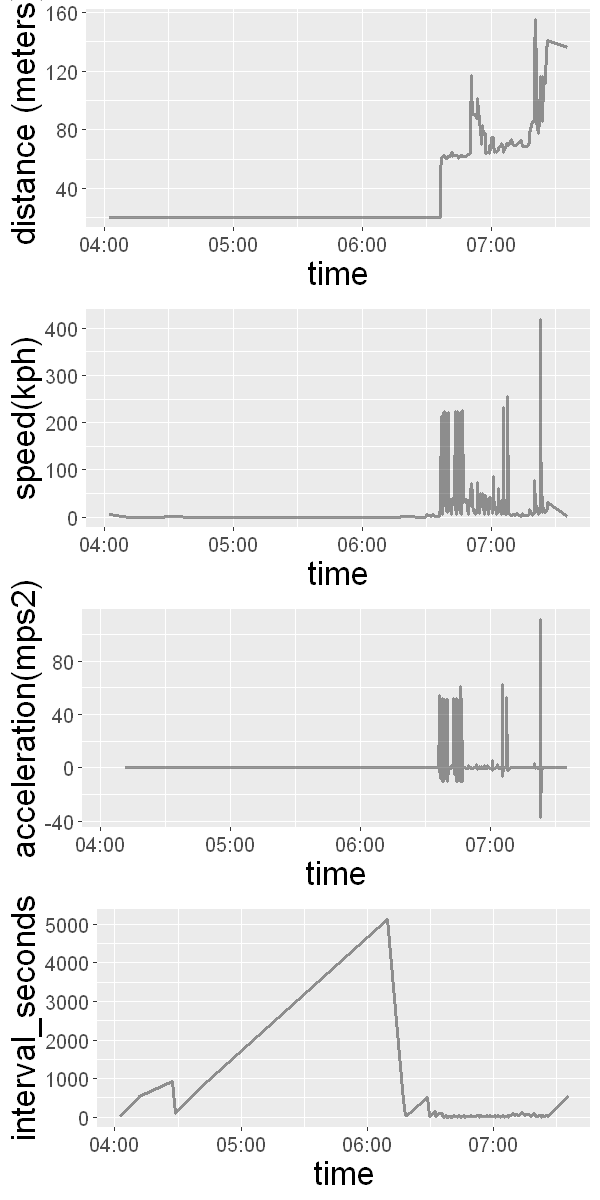

In [47]:
p6 = ggplot(d1_speed_accel) + 
 geom_line(aes(x = time, y=dist_meters),size = 1,alpha = 0.4) +
theme(axis.text=element_text(size = 12),axis.title.x = element_text(size = 20),axis.title.y = element_text(size = 20),title= element_text(size = 20))+
 labs(y = "distance (meters)", x = "time")
p7 =  ggplot(d1_speed_accel) + 
 geom_line(aes(x = time, y=speed_kph),size = 1,alpha = 0.4) +
theme(axis.text=element_text(size = 12),axis.title.x = element_text(size = 20),axis.title.y = element_text(size = 20),title= element_text(size = 20))+
 labs( y = "speed(kph)", x = "time")
p8 = ggplot(d1_speed_accel) + 
 geom_line(aes(x = time, y=accel_mps2),size = 1,alpha = 0.4) +
theme(axis.text=element_text(size = 12),axis.title.x = element_text(size = 20),axis.title.y = element_text(size = 20),title= element_text(size = 20))+
 labs(y = "acceleration(mps2)", x = "time")
p9 = ggplot(d1_speed_accel) + 
 geom_line(aes(x = time, y=interval_seconds),size = 1,alpha = 0.4) +
theme(axis.text=element_text(size = 12),axis.title.x = element_text(size = 20),axis.title.y = element_text(size = 20),title= element_text(size = 20))+
 labs(y = "interval_seconds", x = "time")
options(repr.plot.width = 5, repr.plot.height = 10)
grid.arrange(p6, p7, p8, p9, ncol=1, nrow=4)

In [40]:
d1$dist_meters = filter$level$MED

Warning message in as.POSIXlt.POSIXct(x):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message:
"Removed 1 row(s) containing missing values (geom_path)."
Warning message in as.POSIXlt.POSIXct(x):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning 

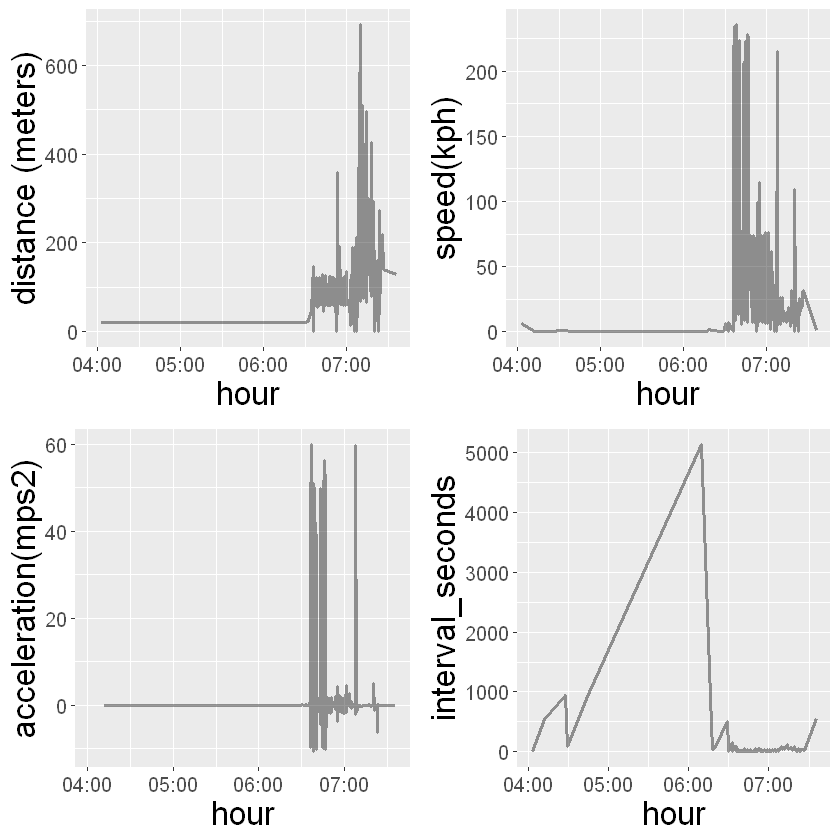

In [36]:
grid.arrange(p1, p2, p3, p4, ncol=2, nrow=2)

In [38]:
#df_test$dist_meters
filter = robreg.filter(df_test_computed$dist_meters, width=20,online=TRUE,method= "MED")

1 out of 255 time series values in df_test_computed$dist_meters are missing. 


In [39]:
filter$level

,MED
,<dbl>
1,20.55303
2,20.55303
3,20.55303
4,20.55303
5,20.55303
6,20.55303
7,20.55303
8,20.55303
9,20.55303


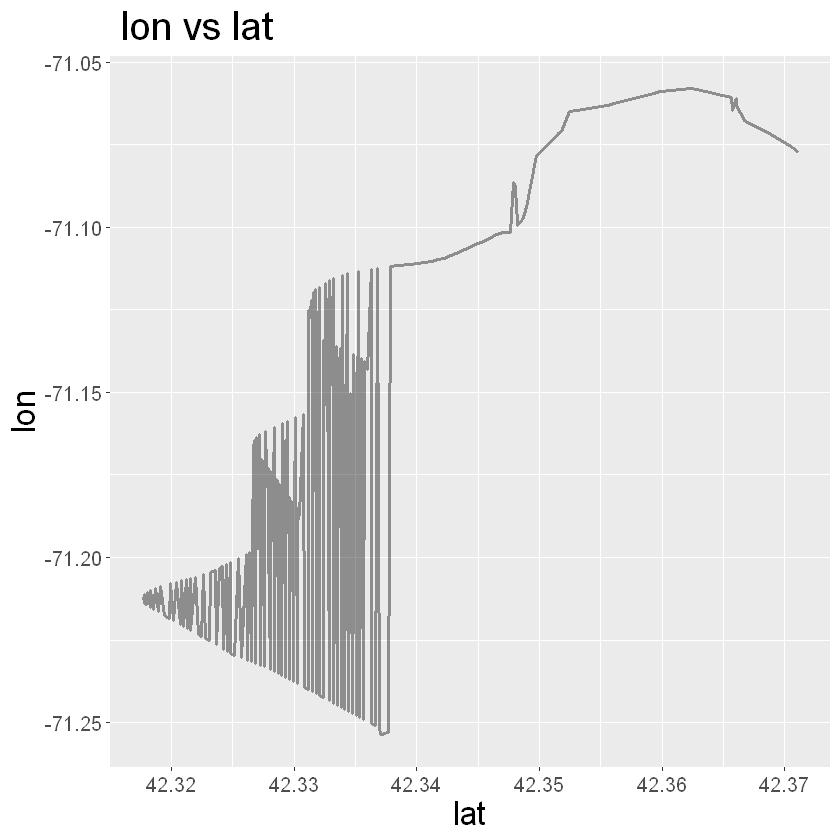

In [63]:
ggplot(df_1_10001_calculate) + 
 geom_line(aes(x=lat, y=lon),size = 1,alpha = 0.4) +
theme(axis.text=element_text(size = 12),axis.title.x = element_text(size = 20),axis.title.y = element_text(size = 20),title= element_text(size = 20))+
 labs(title =" lon vs lat ", y = "lon", x = "lat")

## Vehicle distance,speed, acceleration calculation 
### Spurious values statistics
### Value correction

In [18]:
# Function to compute distances (D), speeds (S) and acceleration (A) in meters, meters per second, km per hour and m s^-2
compute_speed_acceleration <- function(d) {
    d = data.frame(d)
#     d$dist_meters = NA
#     d$dist_meters = as.numeric(d$dist_meters)
#     d$interval_seconds = NA
#     d$interval_seconds = as.numeric(d$interval_seconds)
    d$speed_mps = NA
    d$speed_mps = as.numeric(d$speed_mps)
    d$speed_kph = NA
    d$speed_kph = as.numeric(d$speed_kph)
    d$accel_mps2 = NA
    d$accel_mps2 = as.numeric(d$accel_mps2)
    n <- nrow(d)
    diagnostics = {}
    if (n >= 2) {
#         # Compute interval distance using Haversine function
#         d$dist_meters[2:n] = distHaversine(cbind(d$lon[1:n-1],d$lat[1:n-1]),cbind(d$lon[2:n],d$lat[2:n]))
#         # Compute time interval
#         d$interval_seconds[2:n] = as.numeric(difftime(d$trxtime[2:n], d$trxtime[1:n-1], units = "secs"))
        # Compute speed in meters per second
        d$speed_mps[2:n] = d$dist_meters[2:n] / d$interval_seconds[2:n]
        # Convert speed to kph
        d$speed_kph[2:n] = d$speed_mps[2:n] * 3.6
        # # Compute accelerations
        # d$accel_mps2[2:n] = (d$speed_mps[2:n] - d$speed_mps[1:n-1])/d$interval_seconds[2:n]
        # Spurious values statistics
        index_excessive_speeds = as.numeric(row.names(d[(d$speed_kph > 128) & (!is.na(d$speed_kph)),]))
        # Original data metrics calculation
         diagnostics$mean_original_speed_kph = mean(as.numeric(d[, "speed_kph"]),na.rm=TRUE)
         diagnostics$min_original_speed_kph = min(as.numeric(d[, "speed_kph"]),na.rm=TRUE)
         diagnostics$max_original_speed_kph = max(as.numeric(d[, "speed_kph"]),na.rm=TRUE)
         diagnostics$num_original_speed_kph = length(as.numeric(d[, "speed_kph"]))
        # Excessive data metrics calculation
         diagnostics$mean_excess_speed_kph = mean(as.numeric(d[index_excessive_speeds, "speed_kph"]))
         diagnostics$min_excess_speed_kph = min(d[index_excessive_speeds, "speed_kph"]) 
         diagnostics$max_excess_speed_kph = max(as.numeric(d[index_excessive_speeds, "speed_kph"])) 
         diagnostics$num_excess_speed_kph = length(d[index_excessive_speeds, "speed_kph"]) 
         diagnostics$prop_excess_speed_kph = round(100*diagnostics$num_excess_speed/n, 2)
        # Correct the excessive speed values and recalculate acceleration and distance
        repeat{
        d[index_excessive_speeds, c('speed_kph',"speed_mps")] = d[index_excessive_speeds - 1 , c('speed_kph',"speed_mps")]
        d[index_excessive_speeds, "dist_meters"] = d[index_excessive_speeds, "speed_mps"] * d[index_excessive_speeds,"interval_seconds"]
        # d[index_excessive_speeds, "accel_mps2"] = (d[index_excessive_speeds, "speed_mps"] 
        #                                           - d[index_excessive_speeds - 1, "speed_mps"]) / d[index_excessive_speeds,"interval_seconds"]
        if(max(d$speed_kph,na.rm = TRUE) <= 128){break}
        }
         # Compute accelerations
         d$accel_mps2[2:n] = (d$speed_mps[2:n] - d$speed_mps[1:n-1])/d$interval_seconds[2:n]
        # Correct accelerations
         index_excessive_accelerations = as.numeric(row.names(d[(d$dist_meters == 0) & (d$accel_mps2 > 6),]))
         d[index_excessive_accelerations, "accel_mps2"] = d[index_excessive_accelerations - 1 , "accel_mps2"]
        # Corrected data metrics calculation
         diagnostics$mean_corrected_speed_kph = mean(as.numeric(d[, "speed_kph"]),na.rm=TRUE)
         diagnostics$min_corrected_speed_kph = min(as.numeric(d[, "speed_kph"]),na.rm=TRUE)
         diagnostics$max_corrected_speed_kph = max(as.numeric(d[, "speed_kph"]),na.rm=TRUE)
         diagnostics$num_corrected_speed_kph = length(as.numeric(d[, "speed_kph"]))
    }
    return(list(data = d ,diag_metrics = diagnostics))   
}

In [21]:
# Process calculation 
process_month_trajectory = function(data){
    results_df = data.frame() # empty dataframe
    diagnostics_df = data.frame()
    for(i in unique(data$day)) { 
        data_day <- data[data$day == i, ]
        # Put each train in one loop in a subset
        for (j in unique(data_day$trainid)) {
            data_day_train = data_day[data_day$trainid == j, ]        
            trajectory_and_diagnostics <- compute_trajectories(data_day_train)  
            trajectories = trajectory_and_diagnostics$data
            diagnostics = trajectory_and_diagnostics$diag_metrics          
            results_df <- rbind(results_df, trajectories)
            diagnostics_df <- rbind(diagnostics_df, diagnostics) 
        }
    }
     write.csv(x = results_df, file.path("../../data/tidy/", paste("trajectory", yy, mm, ".csv", sep = "-", collapse = "")))
    write.csv(x = diagnostics_df, file.path("../../data/tidy/", paste("trajectory-diagnostics" , yy, mm, ".csv", sep = "-",collapse = "")))
    # Uncomment the beneath line and check the computation result
    # return(list(result = results_df, result_diag = diagnostics_df ))
 }

In [ ]:
# Generate the final table
main = function(YEARLIST, MONTHLIST) {
    for (y in YEARLIST) {
        for (m in MONTHLIST) {
            df_agg = aggregate_line_trajectories(y, m)
            df_agg = preprocess_data(df_agg)
            process_month_trajectory(df_agg, y, m)            
        }
    }
}

In [ ]:
main(YEARLIST, MONTHLIST)